In [1]:
import pickle
import math
import sys
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
from skimage import draw
from skimage import io
from skimage import transform
import pickle
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import numpy as np
import warnings
from sklearn import metrics
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
plt.rcParams["figure.figsize"] = (10,10)
import pickle
warnings.filterwarnings("ignore")

/home/kti01/miniconda3/envs/artifact_detection/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def confidence_interval(data, size=10000, func=np.mean):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    np.random.seed(42)
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return np.percentile(bs_replicates, [2.5, 97.5])

class DiceScore(nn.Module):
    def __init__(self):
        super(DiceScore, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        num = targets.shape[0]
        inputs = inputs.reshape(num, -1)
        targets = targets.reshape(num, -1)

        intersection = (inputs * targets).sum(1)
        dice = (2. * intersection + smooth) / (inputs.sum(1) + targets.sum(1) + smooth)

        dice = dice.sum() / num

        return dice
        

def polygon2mask(polygon):
    """
    Create an image mask from polygon coordinates
    """
    vertex_row_coords, vertex_col_coords, shape = polygon[:, 1], polygon[:, 0], (450, 600)
    
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=float)
    mask[fill_row_coords, fill_col_coords] = 1.
    mask = transform.resize(mask, (224, 224))
    return mask


def process_annotations(y_annotations):
    masks = [polygon2mask(ann) for ann in y_annotations]
    mask = np.bitwise_or.reduce(masks)
    return mask


predictions_path = "/home/kti01/Documents/My Files/Projects/Overlap/characteristics_classifier/attributions"
phase1_path = "/home/kti01/Documents/My Files/Projects/Overlap/data/phase1"
phase3_path = "/home/kti01/Documents/My Files/Projects/Overlap/data/phase3"
phase2_path = "/home/kti01/Documents/My Files/Projects/Overlap/data/phase2"
metadata_phase1 = pd.read_pickle(os.path.join(phase1_path, "metadata_phase1.pkl"))
metadata_phase3 = pd.read_csv(os.path.join(phase3_path, "metadata_phase3.csv"))
metadata_phase3 = metadata_phase3[~metadata_phase3.issues.isin(['Insufficient Image Quality', 'unzureichende Bildqualität'])]

metadata_phase1['prediction'] = np.floor(metadata_phase1['prediction'])
metadata_phase3['prediction'] = np.floor(metadata_phase3['prediction'])

## Attribution inside vs outside lesion normal

In [3]:
eps = 1e-6

# Normal
segmentation_dir = "/home/kti01/Documents/My Files/Projects/Overlap/data/ham_lesion_segmentations/archive/HAM10000_segmentations_lesion_tschandl"

with open('/home/kti01/Documents/My Files/Projects/Overlap/melanoma_classifier/attributions_dict.pkl', 'rb') as handle:
    attributions_dict_normal = pickle.load(handle)
ratios_normal_mel = {}
ratios_normal_nv = {}
ratios_normal = {}
inside_outside = {}
for image_id in attributions_dict_normal.keys():
    if image_id not in metadata_phase1.image_id.unique():
        continue
    
    if attributions_dict_normal[image_id][0] >= 0.5:
    
        attr = attributions_dict_normal[image_id][1][0]
        mask = io.imread(os.path.join(segmentation_dir, image_id+'_segmentation.png'))
        mask = transform.resize(mask, (224, 224))
        mask[mask == 255] = 1
        ratio = (attr[mask == 1].mean()+eps) / (attr[mask == 0].mean()+eps)
        
        if not math.isinf(ratio) and not math.isnan(ratio):
            ratios_normal_mel[image_id] = ratio 
            
    else:
        attr = attributions_dict_normal[image_id][1][0]
        mask = io.imread(os.path.join(segmentation_dir, image_id+'_segmentation.png'))
        mask = transform.resize(mask, (224, 224))
        mask[mask == 255] = 1
        ratio = (attr[mask == 1].mean()+eps) / (attr[mask == 0].mean()+eps)
        
        
        if not math.isinf(ratio) and not math.isnan(ratio):
            ratios_normal_nv[image_id] = ratio 

ratios_normal = dict(list(ratios_normal_mel.items()) + list(ratios_normal_nv.items()))

## Attribution inside vs outside lesion explainoma

In [4]:
attributions_path = "/home/kti01/Documents/My Files/Projects/Overlap/characteristics_classifier/attributions"

char_labels_full = ['thick reticular or branched lines', 'black dots or globules in the periphery of the lesion', 
                    'white lines or white structureless area', 'eccentrically located structureless area', 'grey patterns',
                    'polymorphous vessels', 'pseudopods or radial lines at the lesion margin that do not occupy the entire lesional circumference',
                    'asymmetric combination of multiple patterns or colours in the absence of other melanoma criteria', 'melanoma simulator', 
                    'only one pattern and only one colour']

metadata_phase2 = pd.read_csv("/home/kti01/Documents/My Files/Projects/Overlap/data/phase2/metadata_phase2.csv")
AI_predictions = dict(zip(metadata_phase2['mask'], metadata_phase2.AI_prediction))
metadata_phase1 = pd.read_pickle("/home/kti01/Documents/My Files/Projects/Overlap/data/phase1/metadata_phase1.pkl")
metadata_phase1['prediction'] = np.floor(metadata_phase1['prediction'])
mask_to_image_id = dict(zip(metadata_phase1['mask'], metadata_phase1['image_id']))


ratios_exp_mel = {}
ratios_exp_nv = {}
ratios_exp = {}

for mask in metadata_phase1['mask'].unique().astype(int):
    
    
    with open(os.path.join(attributions_path, str(mask), str(mask)+'.pkl'), 'rb') as handle:
        attributions = pickle.load(handle)
    
    seg_mask = io.imread(os.path.join(segmentation_dir, mask_to_image_id[mask]+'_segmentation.png'))
    seg_mask = transform.resize(seg_mask, (224, 224))
    seg_mask[seg_mask == 255] = 1
        
    AI_pred = AI_predictions[mask]
    predictions_df = pd.read_csv(os.path.join(attributions_path, str(mask), 'predictions_'+str(mask)+'.csv'))
    
    if AI_pred == 1:
        ratios_per_feature = []
        for i in range(predictions_df.iloc[0:].shape[0]):
            pred = predictions_df.iloc[i].label
            idx = char_labels_full.index(pred)
            attr = attributions[idx]
            ratio = (attr[seg_mask == 1].mean()+eps) / (attr[seg_mask == 0].mean()+eps)
            
            if not math.isinf(ratio) and not math.isnan(ratio):
                ratios_per_feature.append(ratio)
            
        mean_ratio = np.mean(ratios_per_feature)

        ratios_exp_mel[mask_to_image_id[mask]] = mean_ratio
    else:
        ratios_per_feature = []
        for i in range(predictions_df.shape[0]):
            pred = predictions_df.iloc[i].label
            idx = char_labels_full.index(pred)
            attr = attributions[idx]
            ratio = (attr[seg_mask == 1].mean()+eps) / (attr[seg_mask == 0].mean()+eps)
            
            if not math.isinf(ratio) and not math.isnan(ratio):
                ratios_per_feature.append(ratio)
        mean_ratio = np.mean(ratios_per_feature)

        ratios_exp_nv[mask_to_image_id[mask]] = mean_ratio
        
ratios_exp = dict(list(ratios_exp_mel.items()) + list(ratios_exp_nv.items()))

Text(0, 0.5, 'Grad-CAM ratio (inside/outside)')

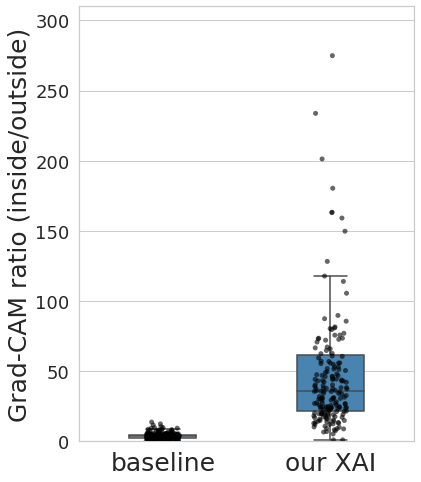

In [5]:
normal = pd.DataFrame().from_dict(ratios_normal, orient='index')
normal.columns = ['baseline']

explainoma = pd.DataFrame().from_dict(ratios_exp, orient='index')
explainoma.columns = ['our XAI']

df = pd.concat([normal, explainoma], ignore_index=True, axis=1)
df.columns = ['baseline', 'our XAI']

#df = np.log2(df)

plt.figure(figsize=(6,8))
palette = sns.color_palette(['grey'], len(df))
sns.boxplot(data=df, width=0.4, showfliers=False, palette='Blues')
plt.legend('', frameon=False)
sns.stripplot(data=df, color='black', alpha=0.6)
plt.yticks(size=18)
plt.xticks(size=25)
#plt.title('Ratio of Mean Pixel Activation Inside Lesion vs Outside', size=15)
plt.ylim(0, 310)
plt.ylabel('Grad-CAM ratio (inside/outside)', size=25)
#plt.savefig('/home/kti01/Documents/My Files/Projects/Overlap/plots/overlap/inside_vs_outside', dpi=500, bbox_inches='tight')

In [11]:
print(df[df['explanatory AI'] > 310].shape)
print(df[df['baseline'] > 310].shape)

(15, 2)
(0, 2)


In [8]:
print(stats.wilcoxon(df['baseline'], df['explanatory AI']))

print(df.baseline.median())
print(confidence_interval(df.baseline, func=np.median))

print(df['explanatory AI'].median())
print(confidence_interval(df['explanatory AI'], func=np.median))
print(df.shape)

WilcoxonResult(statistic=8.0, pvalue=7.350901349070684e-34)
3.4590824598017704
[3.09450758 3.83751522]
35.90850324503222
[30.63953665 42.06477647]
(196, 2)


In [8]:
#df.reset_index().rename({'index': 'image_id'}, axis=1).to_csv('../Source Data/Fig3a.csv', index=False)

(array([[177.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 84.,  62.,  19.,   3.,   2.,   3.,   0.,   1.,   1.,   2.]]),
 array([6.70810289e-02, 3.06824561e+01, 6.12978312e+01, 9.19132064e+01,
        1.22528581e+02, 1.53143957e+02, 1.83759332e+02, 2.14374707e+02,
        2.44990082e+02, 2.75605457e+02, 3.06220832e+02]),
 <a list of 2 BarContainer objects>)

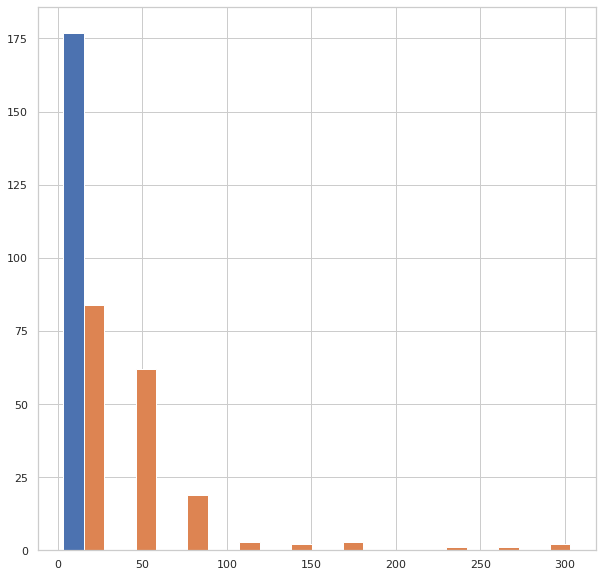

In [8]:
x = df[(df.baseline<500)&(df['explanatory AI']<500)]
plt.hist(x)

In [35]:
x = pd.merge(df, metadata_phase1.set_index('image_id'), left_index=True, right_index=True)
x = x[['baseline', 'explanatory AI', 'prediction']]
x = pd.melt(x, 'prediction')
x.head()

,prediction,variable,value
0,0.0,baseline,2.137064
1,0.0,baseline,2.137064
2,0.0,baseline,2.137064
3,0.0,baseline,2.137064
4,0.0,baseline,2.137064


(0.0, 300.0)

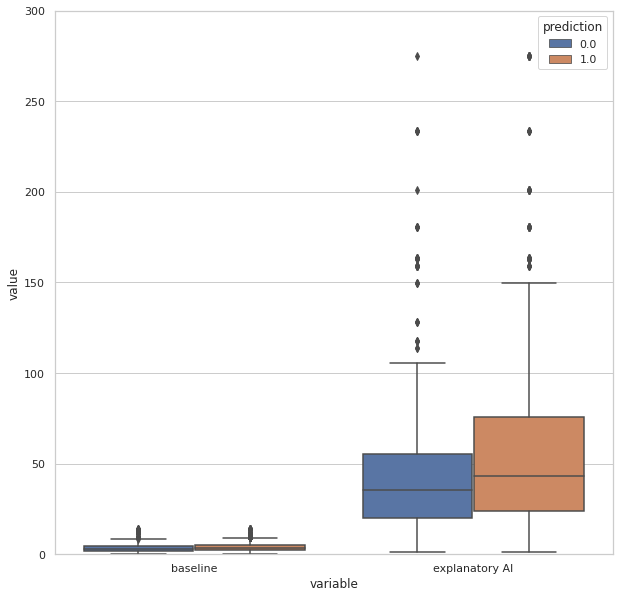

In [38]:
sns.boxplot(
    data=x, x="variable", y="value", hue="prediction",
    dodge=True, zorder=1
)
plt.ylim(0, 300)